In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *
import statsmodels.api as sm

# Define the FarmEnv class
# class FarmEnv:
#     def __init__(self, farm: Farm, reward_function=None):
#         self.game = farm  # Accept a Farm instance directly
#         self.done = False
#         self.reward_function = reward_function or self.default_reward

#     def reset(self):
#         self.game = configure_game()  # Reset the game
#         self.done = False
#         return self.get_state()

#     def step(self, action):
#         current_player = self.game.whose_turn()["name"]
#         self.game = self.game.take_action(action, inplace=True)  # Apply action
#         reward = self.reward_function(self.game, current_player)  # Calculate reward
#         self.done = self.game.is_done()  # Check if game is done
#         new_state = self.get_state()  # Get the updated state
#         return new_state, reward, self.done, {}  # Return updated state

#     def get_state(self):
#         return self.map

#     def render(self):
#         self.game.print_farm()

#     def default_reward(self, game, player):


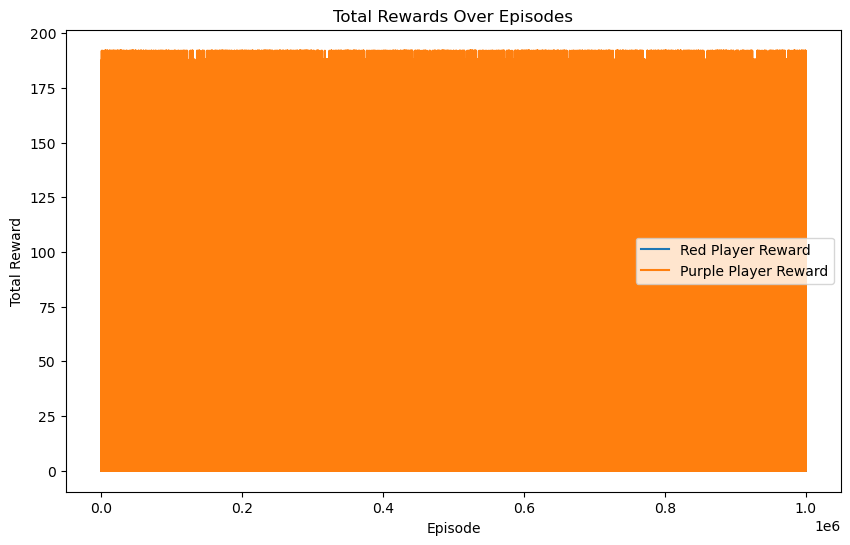

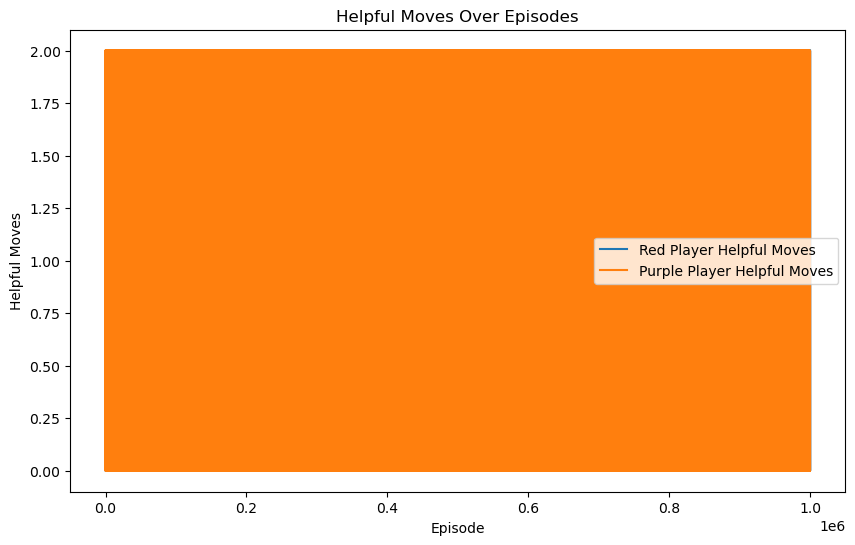

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

class QLearningAgent:
    def __init__(self, learning_rate, discount_factor, epsilon, color, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.color = color

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, int(1e6))
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        Assuming 'state' is an object with properties that can be converted to hashable types.
        """
        if self.color == "red":
            player = state.redplayer
        else:
            player = state.purpleplayer

        agents = tuple((player['loc']['x'], player['loc']['y']))
        energy_levels = player['energy']
        return (agents, energy_levels)

    def get_action_representation(self, action):
        return (action.type, action.color)  # Simplified action representation

    def get_q_value(self, state, action):
        state_rep = self.get_state_representation(state)
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        actions = self.current_state.legal_actions()
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            return random.choice(actions)

        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        return random.choice(best_actions)

    def update_q_value(self, action, reward, next_state):
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        next_actions = next_state.legal_actions()
        max_q_next = max([self.get_q_value(next_state, a) for a in next_actions], default=0)

        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

    def decay_epsilon(self, decay_rate=0.99):
        self.epsilon = max(0.01, self.epsilon * decay_rate)


def train_q_learning_agent(learning_rate, discount_factor, epsilon, num_episodes, max_steps_per_episode=100):
    agent1 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color="red")
    agent2 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color="purple")

    game_data = []

    for episode in range(num_episodes):
        state = farmgame.configure_game(layer="Simple", resourceCond="even", costCond="low", visibilityCond="full", redFirst=True)
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0
        purple_helpful_count = 0
        total_steps = 0

        for step in range(max_steps_per_episode):
            total_steps += 1

            # Red player action
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            reward1, done = next_state.reward("red")
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break

            # Purple player action
            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break

        # Collect data for the episode
        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")

        game_data.append({
            "episode": episode + 1,
            "red_reward": red_rwd,
            "purple_reward": purple_rwd,
            "red_helpful_moves": red_helpful_count,
            "purple_helpful_moves": purple_helpful_count,
            "total_steps": total_steps,
            "helping_event": red_helpful_count + purple_helpful_count,
        })

        # Decay epsilon
        agent1.decay_epsilon()
        agent2.decay_epsilon()

    # Convert game data into a DataFrame
    game_df = pd.DataFrame(game_data)
    return agent1, agent2, game_df


# Train Q-learning agents
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1
num_episodes = 1000000

agent1, agent2, game_df = train_q_learning_agent(
    learning_rate=learning_rate, 
    discount_factor=discount_factor, 
    epsilon=epsilon, 
    num_episodes=num_episodes
)

# Plot total rewards
plt.figure(figsize=(10, 6))
plt.plot(game_df["red_reward"], label="Red Player Reward")
plt.plot(game_df["purple_reward"], label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()

# Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(game_df["red_helpful_moves"], label="Red Player Helpful Moves")
plt.plot(game_df["purple_helpful_moves"], label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


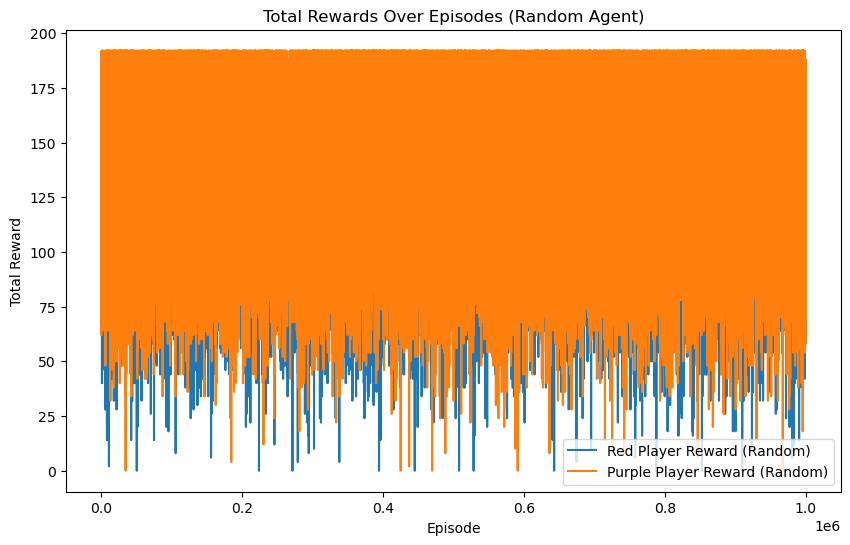

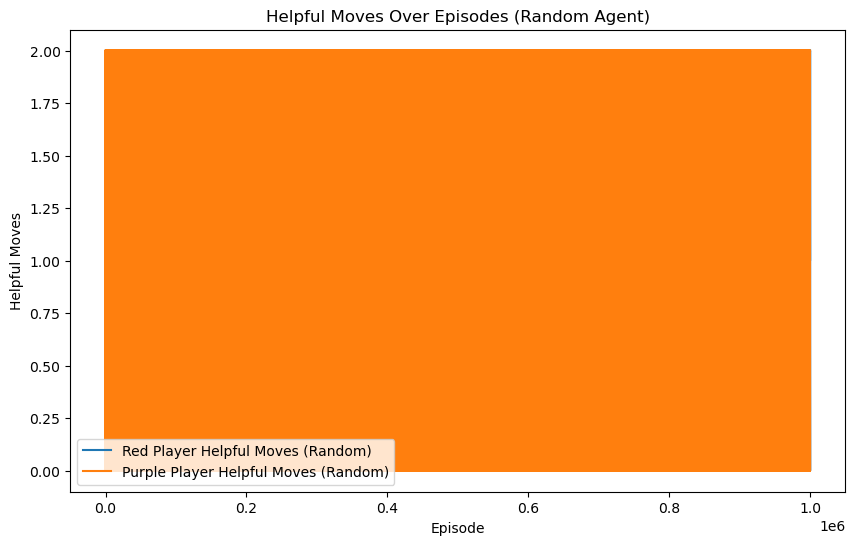

In [35]:
class RandomAgent:
    def __init__(self, color):
        self.color = color
        self.current_state = None

    def update(self, state):
        self.current_state = state

    def choose_action(self):
        actions = self.current_state.legal_actions()
        if not actions:
            raise Exception("No legal actions available.")
        return random.choice(actions)

def train_random_agent(num_episodes, max_steps_per_episode=100):
    agent1 = RandomAgent(color="red")
    agent2 = RandomAgent(color="purple")

    random_data = []

    for episode in range(num_episodes):
        state = farmgame.configure_game(
            layer="Simple", resourceCond="even", costCond="low", visibilityCond="full", redFirst=True
        )
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0
        purple_helpful_count = 0
        total_steps = 0

        for step in range(max_steps_per_episode):
            total_steps += 1
            
            # Red player action
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            reward1, done = next_state.reward("red")
            state = next_state

            if done:
                break

            # Purple player action
            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")
            state = next_state

            if done:
                break

        # Collect data for the episode
        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")

        random_data.append({
            "episode": episode + 1,
            "red_reward": red_rwd,
            "purple_reward": purple_rwd,
            "red_helpful_moves": red_helpful_count,
            "purple_helpful_moves": purple_helpful_count,
            "total_steps": total_steps
        })

    # Convert random agent data into a DataFrame
    random_df = pd.DataFrame(random_data)
    return random_df

# Train the random agent
num_episodes = 1000000
random_df = train_random_agent(num_episodes=num_episodes)

# Plot results for comparison
import matplotlib.pyplot as plt

# Total rewards comparison
plt.figure(figsize=(10, 6))
plt.plot(random_df["red_reward"], label="Red Player Reward (Random)")
plt.plot(random_df["purple_reward"], label="Purple Player Reward (Random)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes (Random Agent)")
plt.legend()
plt.show()

# Helpful moves comparison
plt.figure(figsize=(10, 6))
plt.plot(random_df["red_helpful_moves"], label="Red Player Helpful Moves (Random)")
plt.plot(random_df["purple_helpful_moves"], label="Purple Player Helpful Moves (Random)")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes (Random Agent)")
plt.legend()
plt.show()


In [15]:
# List columns in game_df and random_df
print("game_df columns:", game_df.columns.tolist())
print("random_df columns:", random_df.columns.tolist())


game_df columns: ['episode', 'red_reward', 'purple_reward', 'red_helpful_moves', 'purple_helpful_moves', 'total_steps', 'helping_event']
random_df columns: ['episode', 'red_reward', 'purple_reward', 'red_helpful_moves', 'purple_helpful_moves', 'total_steps']


In [37]:
from scipy.stats import mannwhitneyu

# Extract the rewards for both agents
q_learning_red_rewards = game_df['red_reward']
q_learning_purple_rewards = game_df['purple_reward']
random_red_rewards = random_df['red_reward']
random_purple_rewards = random_df['purple_reward']

# Perform Mann-Whitney U tests
red_u_stat, red_p_value = mannwhitneyu(q_learning_red_rewards, random_red_rewards, alternative='greater')
purple_u_stat, purple_p_value = mannwhitneyu(q_learning_purple_rewards, random_purple_rewards, alternative='greater')

# Print results
print(f"Red Player - U Statistic: {red_u_stat}, P-Value: {red_p_value}")
print(f"Purple Player - U Statistic: {purple_u_stat}, P-Value: {purple_p_value}")


Red Player - U Statistic: 334743645018.5, P-Value: 1.0
Purple Player - U Statistic: 296022460463.0, P-Value: 1.0


In [39]:
print("Q-Learning Red Rewards Mean:", q_learning_red_rewards.mean())
print("Random Red Rewards Mean:", random_red_rewards.mean())
print("Q-Learning Red Rewards Std:", q_learning_red_rewards.std())
print("Random Red Rewards Std:", random_red_rewards.std())


Q-Learning Red Rewards Mean: 99.760233
Random Red Rewards Mean: 154.24477
Q-Learning Red Rewards Std: 66.90974970607013
Random Red Rewards Std: 17.394238419857377


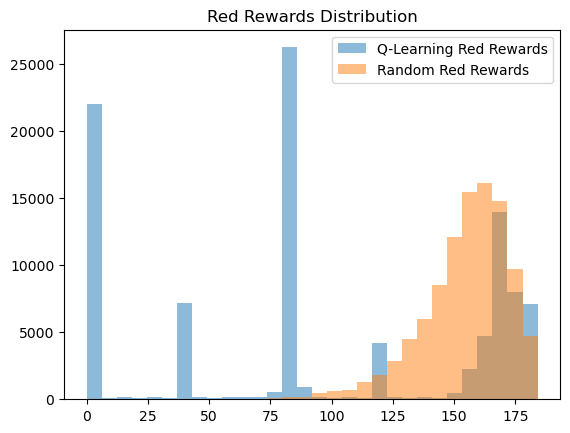

In [21]:
import matplotlib.pyplot as plt

plt.hist(q_learning_red_rewards, alpha=0.5, label='Q-Learning Red Rewards', bins=30)
plt.hist(random_red_rewards, alpha=0.5, label='Random Red Rewards', bins=30)
plt.legend()
plt.title("Red Rewards Distribution")
plt.show()


In [23]:
from scipy.stats import mannwhitneyu

# Extract the final 200 episodes of rewards
q_learning_red_rewards_last_200 = game_df['red_reward'][-200:]
q_learning_purple_rewards_last_200 = game_df['purple_reward'][-200:]
random_red_rewards_last_200 = random_df['red_reward'][-200:]
random_purple_rewards_last_200 = random_df['purple_reward'][-200:]

# Perform Mann-Whitney U test for Red Player
red_u_stat, red_p_value = mannwhitneyu(
    q_learning_red_rewards_last_200, 
    random_red_rewards_last_200, 
    alternative='greater'
)

# Perform Mann-Whitney U test for Purple Player
purple_u_stat, purple_p_value = mannwhitneyu(
    q_learning_purple_rewards_last_200, 
    random_purple_rewards_last_200, 
    alternative='greater'
)

# Print the results
print(f"Red Player (Last 200 Episodes) - U Statistic: {red_u_stat}, P-Value: {red_p_value}")
print(f"Purple Player (Last 200 Episodes) - U Statistic: {purple_u_stat}, P-Value: {purple_p_value}")


Red Player (Last 200 Episodes) - U Statistic: 15085.5, P-Value: 0.9999898238077313
Purple Player (Last 200 Episodes) - U Statistic: 11364.0, P-Value: 0.9999999999999646


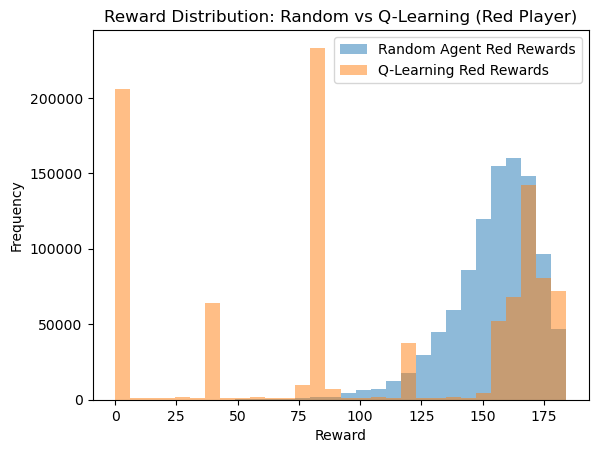

In [41]:
import matplotlib.pyplot as plt

plt.hist(random_red_rewards, alpha=0.5, label='Random Agent Red Rewards', bins=30)
plt.hist(q_learning_red_rewards, alpha=0.5, label='Q-Learning Red Rewards', bins=30)
plt.legend()
plt.title("Reward Distribution: Random vs Q-Learning (Red Player)")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()


In [32]:
q_learning_red_rewards

0        164
1          0
2         46
3         98
4        170
        ... 
99995     80
99996    178
99997    178
99998    170
99999    120
Name: red_reward, Length: 100000, dtype: int64

In [43]:
# Extract the final 200 episodes for Q-learning
q_learning_red_rewards_last_200 = game_df["red_reward"][-200:]
q_learning_purple_rewards_last_200 = game_df["purple_reward"][-200:]

# Extract the final 200 episodes for Random Agent
random_red_rewards_last_200 = random_df["red_reward"][-200:]
random_purple_rewards_last_200 = random_df["purple_reward"][-200:]

# Calculate and print means and standard deviations for Red player
print("Q-Learning Red Rewards Mean (Last 200):", q_learning_red_rewards_last_200.mean())
print("Random Red Rewards Mean (Last 200):", random_red_rewards_last_200.mean())
print("Q-Learning Red Rewards Std (Last 200):", q_learning_red_rewards_last_200.std())
print("Random Red Rewards Std (Last 200):", random_red_rewards_last_200.std())

# Calculate and print means and standard deviations for Purple player
print("Q-Learning Purple Rewards Mean (Last 200):", q_learning_purple_rewards_last_200.mean())
print("Random Purple Rewards Mean (Last 200):", random_purple_rewards_last_200.mean())
print("Q-Learning Purple Rewards Std (Last 200):", q_learning_purple_rewards_last_200.std())
print("Random Purple Rewards Std (Last 200):", random_purple_rewards_last_200.std())


Q-Learning Red Rewards Mean (Last 200): 102.495
Random Red Rewards Mean (Last 200): 154.2
Q-Learning Red Rewards Std (Last 200): 67.86566671442168
Random Red Rewards Std (Last 200): 18.678986123798722
Q-Learning Purple Rewards Mean (Last 200): 92.68
Random Purple Rewards Mean (Last 200): 158.06
Q-Learning Purple Rewards Std (Last 200): 70.66893299358823
Random Purple Rewards Std (Last 200): 18.97992592029006


In [45]:
# Extract the final 200 episodes of helpful moves for Q-learning
q_learning_red_helpful_last_200 = game_df["red_helpful_moves"][-200:]
q_learning_purple_helpful_last_200 = game_df["purple_helpful_moves"][-200:]

# Extract the final 200 episodes of helpful moves for Random Agent
random_red_helpful_last_200 = random_df["red_helpful_moves"][-200:]
random_purple_helpful_last_200 = random_df["purple_helpful_moves"][-200:]

# Calculate and print means and standard deviations for Red player's helpful moves
print("Q-Learning Red Helpful Moves Mean (Last 200):", q_learning_red_helpful_last_200.mean())
print("Random Red Helpful Moves Mean (Last 200):", random_red_helpful_last_200.mean())
print("Q-Learning Red Helpful Moves Std (Last 200):", q_learning_red_helpful_last_200.std())
print("Random Red Helpful Moves Std (Last 200):", random_red_helpful_last_200.std())

# Calculate and print means and standard deviations for Purple player's helpful moves
print("Q-Learning Purple Helpful Moves Mean (Last 200):", q_learning_purple_helpful_last_200.mean())
print("Random Purple Helpful Moves Mean (Last 200):", random_purple_helpful_last_200.mean())
print("Q-Learning Purple Helpful Moves Std (Last 200):", q_learning_purple_helpful_last_200.std())
print("Random Purple Helpful Moves Std (Last 200):", random_purple_helpful_last_200.std())


Q-Learning Red Helpful Moves Mean (Last 200): 1.08
Random Red Helpful Moves Mean (Last 200): 1.125
Q-Learning Red Helpful Moves Std (Last 200): 0.9153081146387911
Random Red Helpful Moves Std (Last 200): 0.6720365807224676
Q-Learning Purple Helpful Moves Mean (Last 200): 0.86
Random Purple Helpful Moves Mean (Last 200): 0.97
Q-Learning Purple Helpful Moves Std (Last 200): 0.8799269042277988
Random Purple Helpful Moves Std (Last 200): 0.6490038752971774


In [ ]:
# 